In [1]:
import sys, os, time, shutil, random
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from scipy import misc, signal

import torch
from torch.nn import functional as F

from sklearn.neighbors import NearestNeighbors
import networkx as nx
import cv2
import random
import ctypes
from scipy.signal import convolve2d, correlate2d
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import Counter
import io
from sklearn.neighbors import NearestNeighbors
import networkx as nx

from omnibelt import load_yaml, save_yaml, multi_index

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import *
from skimage.segmentation import watershed, expand_labels
from skimage.morphology import closing, square, dilation
from skimage.color import label2rgb
from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [5]:
root = Path('extra/balkans')

In [52]:
rgba = Image.open(root/'borders.png').convert('RGBA')
rgba = np.asarray(rgba)
rgb = rgba[...,:3]
lbls = np.array(Image.open(root/'regions.png'))
tileimg = np.array(Image.open(root/'tiles.png'))
lbls.shape, rgb.shape, tileimg.shape

((4442, 4405), (4442, 4405, 3), (4442, 4405))

In [53]:
_fsize = (6,6)
def showx(im, cover=lbls):
    plt.figure(figsize=_fsize)
    try:
        plt.imshow(im.astype(int))
        if cover is not None:
            plt.imshow(cover%1000, alpha=0., zorder=10)
    except ValueError:
        plt.imshow(im)
    
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)
    
def get_highlight(rgb, mask, opacity=0.2):
    alpha = np.zeros_like(mask).astype(np.uint8)
    
    img = rgb.astype(np.uint8)
    
    alpha[mask!=0] = 255
    alpha[mask==0] = int(255*opacity)
    
    H,W,C = img.shape
    
    if C == 4:
        img[...,-1] = alpha
    else:
        img = np.concatenate([img, alpha.reshape(H,W,1)],-1)
    return img
    
def highlight(rgb, mask, opacity=0.2, cover=lbls):
    img = get_highlight(rgb, mask, opacity=opacity)
    return showx(img, cover=cover)
    
def coords_order(coords):

    clf = NearestNeighbors(n_neighbors=2).fit(coords)
    G = clf.kneighbors_graph()
    T = nx.from_scipy_sparse_matrix(G)

    orders = [np.array(list(nx.dfs_preorder_nodes(T, min(piece))), dtype='int')
              for piece in nx.connected_components(T)]
    return orders
    
# showx(lbls)

In [54]:
nodes = load_yaml(root/'nodes.yaml')
# for node in nodes:
#     node['type'] = node['env']
nodeIDs = {node['ID']:node for node in nodes}
len(nodes)

97

In [55]:
filled = expand_labels(lbls,100)
(filled==0).sum()

0

In [56]:
borders = find_boundaries(filled, mode='thick')
# showx(borders)

In [57]:
clean = filled.copy()
clean[borders==1] = 0
# showx(clean)

In [58]:
regions = regionprops(lbls)
regions.insert(0,None)
len(regions)

115

In [59]:
tiles = regionprops(tileimg)
tiles.insert(0,None)
len(tiles)

154

In [60]:
# plt.figure()
# plt.hist(areas, bins=100);

In [61]:
mxs = []
for node in nodes:
    mxs.append(max(tiles[t].area for t in node['tiles']))
sup = min(mxs)
sup

16262

In [62]:
fixed = lbls.copy()
for i, tile in tqdm(enumerate(tiles[1:]), total=len(tiles)-1):
    i += 1
    if tile.area < sup:
        fixed[tileimg==i] = 0
fixed = expand_labels(fixed,100)
(fixed==0).sum()

  0%|          | 0/153 [00:00<?, ?it/s]

0

In [63]:
neighbors = {}

In [64]:
for idx, node in tqdm(nodeIDs.items()):
    if idx not in neighbors:
        reg = regionprops(find_boundaries(fixed == idx, mode='outer').astype(int))[0]
        ords = coords_order(reg.coords)
        nss = [set(fixed[tuple(reg.coords[o].T)]) for o in ords]

        ans = set()
        nts = []
        for i, ns in enumerate(nss):
            ns = {n for n in ns if n not in ans and n in nodeIDs}
            ans.update(ns)
            if len(ns):
                nts.append(ns)
        neighbors[idx] = nts

  0%|          | 0/97 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [65]:
neighbors = {1: [{17, 2, 11, 13}], 2: [{1, 3, 17, 7}], 3: [{2, 4, 7, 8, 12}], 4: [{8, 9, 3, 5}], 5: [{9, 10, 4, 6}], 6: [{10, 5}], 7: [{17, 2, 3, 12}], 8: [{3, 4, 9, 12, 14}], 9: [{4, 5, 8, 10, 14, 16}], 10: [{5, 6, 9, 15, 16}], 11: [{1, 13, 23, 24, 31}], 12: [{3, 7, 8, 14, 17, 19}], 13: [{1, 11, 17, 23}], 14: [{8, 9, 12, 16, 18, 19, 20}], 15: [{16, 10, 35, 21}], 16: [{9, 10, 14, 15, 18, 21}], 17: [{1, 2, 7, 12, 13, 19, 22, 23, 26, 27, 28}], 18: [{14, 16, 20, 21, 25}], 19: [{12, 14, 17, 20, 22, 29}], 20: [{33, 14, 18, 19, 25, 29}], 21: [{35, 40, 43, 15, 16, 18, 25}], 22: [{17, 19, 28, 29, 30}], 23: [{37, 39, 11, 13, 17, 26, 31}], 24: [{39, 42, 11, 46, 58, 31}], 25: [{33, 40, 18, 20, 21}], 26: [{32, 37, 17, 23, 27}], 27: [{32, 17, 26, 28}], 28: [{32, 34, 38, 41, 17, 22, 27, 30}], 29: [{33, 36, 19, 20, 22, 30}], 30: [{34, 36, 22, 28, 29}], 31: [{24, 11, 23, 39}], 32: [{37, 41, 44, 26, 27, 28}], 33: [{36, 40, 45, 50, 20, 25, 29}], 34: [{36, 38, 45, 49, 28, 30}], 35: [{43, 68, 21, 15}], 36: [{33, 34, 45, 29, 30}], 37: [{32, 39, 42, 44, 46, 47, 23, 26}], 38: [{34, 41, 48, 49, 28}], 39: [{37, 42, 23, 24, 31}], 40: [{33, 43, 50, 21, 25}], 41: [{32, 38, 44, 48, 28}], 42: [{24, 37, 46, 39}], 43: [{35, 67, 68, 71, 40, 50, 21, 54, 63}], 44: [{32, 37, 41, 47, 48, 51}], 45: [{33, 34, 36, 49, 50, 52, 56}], 46: [{37, 42, 47, 53, 24, 58}], 47: [{37, 44, 46, 51, 53, 57, 61}], 48: [{38, 41, 44, 49, 51}], 49: [{34, 38, 45, 48, 51, 52, 55}], 50: [{33, 40, 43, 45, 54, 56, 59}], 51: [{70, 44, 47, 48, 49, 55, 60, 61}], 52: [{45, 49, 55, 56, 62}], 53: [{64, 65, 46, 47, 57, 58}], 54: [{43, 50, 59, 63}], 55: [{69, 49, 51, 52, 60, 62}], 56: [{45, 50, 52, 59, 62}], 57: [{65, 61, 53, 47}], 58: [{64, 75, 76, 46, 53, 24}], 59: [{66, 74, 50, 54, 56, 62, 63}], 60: [{51, 69, 70, 55}], 61: [{65, 70, 72, 73, 47, 51, 57}], 62: [{69, 74, 52, 55, 56, 59}], 63: [{66, 67, 71, 43, 54, 59}], 64: [{65, 72, 75, 53, 58}], 65: [{64, 72, 53, 57, 61}], 66: [{74, 59, 63, 71}], 67: [{43, 63, 71}], 68: [{35, 71, 43, 81, 83}], 69: [{70, 74, 77, 78, 80, 55, 60, 62}], 70: [{69, 73, 80, 51, 60, 61}], 71: [{66, 67, 68, 74, 43, 81, 63}], 72: [{64, 65, 73, 75, 79, 61}], 73: [{70, 72, 79, 80, 82, 85, 86, 61}], 74: [{66, 69, 71, 78, 81, 87, 88, 59, 62}], 75: [{64, 72, 76, 79, 58}], 76: [{58, 75, 79, 82, 89, 90}], 77: [{80, 69, 78}], 78: [{69, 74, 77, 80, 84, 86, 87, 91, 92, 94}], 79: [{72, 73, 75, 76, 82}], 80: [{69, 70, 73, 77, 78, 84, 86}], 81: [{68, 71, 74, 83, 88, 93}], 82: [{73, 76, 79, 85, 89}], 83: [{81, 68, 93, 95}], 84: [{80, 78, 86}], 85: [{73, 82, 86, 89, 94}], 86: [{73, 78, 80, 84, 85, 94}], 87: [{88, 74, 91, 78}], 88: [{74, 81, 87, 91, 93, 95}], 89: [{96, 97, 76, 82, 85, 90, 91, 94}], 90: [{89, 76}], 91: [{97, 78, 87, 88, 89, 92, 94}], 92: [{78, 91, 94}], 93: [{88, 81, 83, 95}], 94: [{78, 85, 86, 89, 91, 92}], 95: [{88, 83, 93}], 96: [{89, 97}], 97: [{96, 89, 91}]}
# print(neighbors)

In [66]:
ntx = {idx:{n for ns in nss for n in ns} for idx, nss in neighbors.items()}
len(ntx)

97

In [68]:
seanet = {i:{n for n in ntx[i] if nodeIDs[n]['env'] == 'sea'} for i, node in nodeIDs.items() if node['env'] == 'sea'}
len(seanet)

14

In [143]:
edges = {}
for idx in tqdm([i for i in nodeIDs if i not in edges]):
    node = nodeIDs[idx]
    ns = ntx[idx]
    es = {}
    
    seas = {n for n in ns if nodeIDs[n]['type'] == 'sea'}
    if node['type'] == 'sea':
        es['fleet'] = set(ns)
    else:
        es['army'] = set(ns-seas)
        if len(seas):
            node['type'] = 'coast'
            coasts = []
            while len(seas):
                sea = seas.pop()
                
                for coast in coasts:
                    if coast.intersection(ntx[sea]):
                        coast.add(sea)
                        break
                else:
                    coasts.append({sea})
            
            if len(coasts) > 1:
                joined = [coasts[0]]
                for coast in coasts[1:]:
                    seeds = {n for s in coast for n in ntx[s] if nodeIDs[n]['type'] == 'sea'}
                    for sel in joined:
                        if seeds.intersection(sel):
                            sel.update(coast)
                            break
                    else:
                        joined.append(coast)
                coasts = joined
                
            lands = [{l for c in coast for l in ntx[c] if l in ns and nodeIDs[l]['type'] != 'sea'} for coast in coasts]
            fleet = {i:{*f, *a} for i,(f,a) in enumerate(zip(coasts,lands))}
            es['fleet'] = fleet[0] if len(fleet) == 1 else fleet
    edges[idx] = es
    
len(edges)

# edges = {}
# for idx in tqdm([i for i in nodeIDs if i not in edges]):
#     node = nodeIDs[idx]
#     ns = ntx[idx]
#     es = {}
    
#     seas = {n for n in ns if n in seanet}
#     if node['env'] == 'sea':
#         node['type'] = 'sea'
#         es['fleet'] = set(ns)
#     else:
#         node['type'] = 'land'
#         es['army'] = set(ns-seas)
#         if len(seas):
#             node['type'] = 'coast'
#             coasts = []
#             while len(seas): # TODO: check for a peninsula
#                 sea = seas.pop()
#                 overlap = seas.intersection(seanet[sea])
#                 overlap.add(sea)
#                 for coast in coasts:
#                     if len(overlap.intersection(coast)):
#                         coast.update(overlap)
#                 else:
#                     coasts.append(overlap)
#                 if idx == 81:
#                     print(sea, overlap, seas, coasts)
#                 seas = set(seas - overlap)
#             for coast in coasts:
#                 coast.update({n for c in coast for n in ntx[c]}.intersection(es['army']))
#             coasts = [c for c in coasts if len(c)]
#             es['fleet'] = coasts[0] if len(coasts) == 1 else coasts
#     edges[idx] = es
    
# len(edges)

  0%|          | 0/97 [00:00<?, ?it/s]

97

In [144]:
# idx = 10
# print(nodeIDs[idx])
# print(edges[idx])
# highlight(rgb, lbls==idx)

In [145]:
# manual edges
edges[94] = {'army': {92, 85, 86}, 'fleet': [{86, 78, 92}, {85, 89}]}
edges[63] = {'army': {54, 59, 66, 67}, 'fleet': [{54, 43, 67}, {67, 71, 66}]}
edges[68] = {'army': {67, 83, 81}, 'fleet': [{35, 43, 67}, {67, 71, 81}]}
edges[89]['fleet'].add(91)
edges[91]['fleet'].add(89)
edges[83]['army'].add(6)
edges[6]['army'].add(83)
edges[68]['army'].add(67)
edges[67]['army'].add(68)
edges[97]['fleet'].update({89, 91})
edges[89]['fleet'].add(97)
edges[91]['fleet'].add(97)
edges[87]['fleet'] = {78, 74, 91, 88}

In [146]:
assignments = {94: {0: 'ec', 1: 'wc'}, 63: {0: 'nc', 1: 'sc'}, 68: {0: 'nc', 1: 'sc'}, }

In [147]:
for idx, node in nodeIDs.items():
    node['edges'] = {t:[('{}-{}'.format(nodeIDs[e[0]]['name'], assignments[e[0]][e[1]]) 
                         if isinstance(e, tuple) else nodeIDs[e]['name']) 
                        for e in es]
                     for t, es in edges[idx].items() if not (isinstance(es, list) and len(es) > 1)}
    if 'fleet' in edges[idx] and isinstance(edges[idx]['fleet'], list) and len(edges[idx]['fleet']) > 1:
        node['edges']['fleet'] = {assignments[idx][k]: [('{}-{}'.format(nodeIDs[e[0]]['name'], assignments[e[0]][e[1]]) 
                                                         if isinstance(e, tuple) 
                                                         else nodeIDs[e]['name']) 
                                                        for e in es] for k,es in enumerate(edges[idx]['fleet'])}

In [148]:
graph = {node['name']: node for node in nodes}
len(graph)

97

<IPython.core.display.Javascript object>


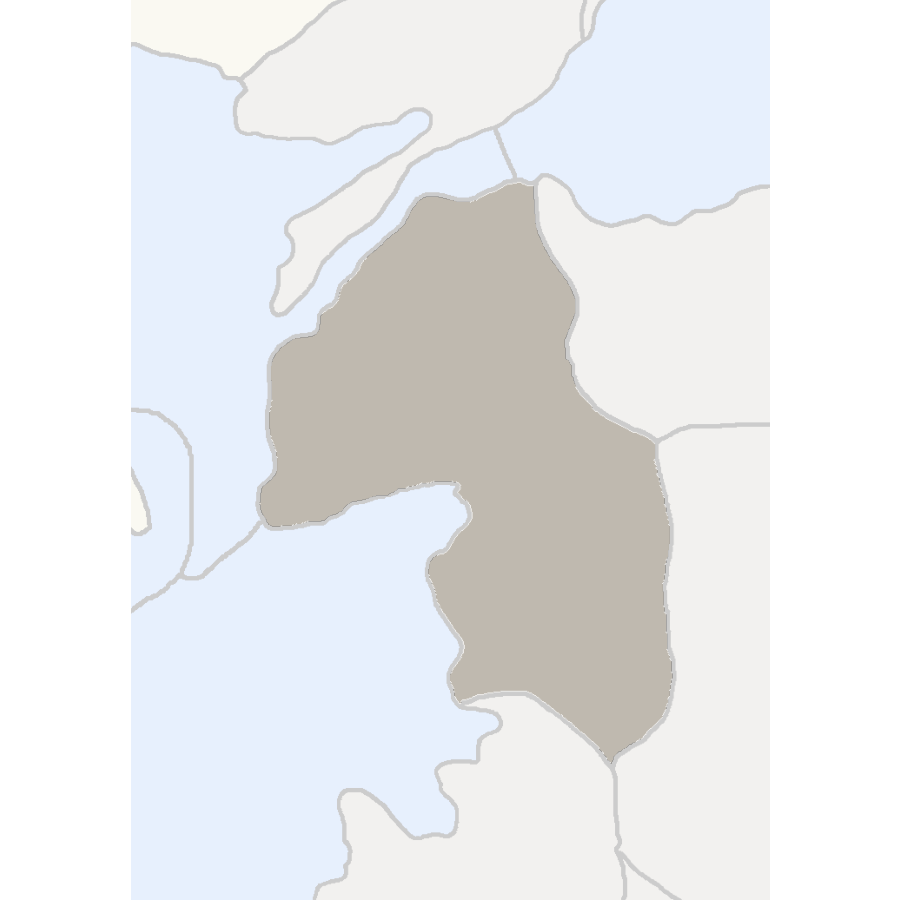

{'army': {83, 68, 93}, 'fleet': {68, 71, 88, 74, 93}}


{'ID': 81,
 'env': 'land',
 'name': 'KAL',
 'tiles': [117],
 'type': 'coast',
 'edges': {'army': ['CAT', 'BRS', 'SMY'],
  'fleet': ['BRS', 'DAR', 'CES', 'TEP', 'SMY']}}

In [149]:
node = random.choice(nodes)
node = graph['ROD']
node = nodeIDs[81]
highlight(rgb, lbls==node['ID'])
print(edges[node['ID']])
node

In [150]:
# save_yaml(graph, root/'graph.yaml')

In [9]:
# Image.fromarray(clean.astype(np.int16)).save(root / "clean.png")
# Image.fromarray(((clean!=0)*255).astype(np.uint8)).save(root / "borders.png")